In [4]:
from source.metrics import DeputiesNetwork
from source.utils import *
from source.plot import CORES_PARTIDOS

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

In [5]:
ANO_INICIO = 2019
ANO_FIM = 2024

In [6]:
rocket = sns.color_palette("rocket", as_cmap=True)
mako = sns.color_palette("mako_r", as_cmap=True)

new_colors = np.vstack((rocket(np.linspace(0, 1, 128)),
                        mako(np.linspace(0, 1, 128))))

# Criando uma versão mais contrastada: enfatizando os extremos e reduzindo branco
contrast_cmap = LinearSegmentedColormap.from_list(
    "rocket-mako",
    new_colors
)

# Análise das redes e os resumos de discursos

Esse Jupyter Notebook é para realizar a análise das redes de deputados e reconhecer padrões que possam ser explicados e entendidos pelos resumos dos discursos. Esses padrões podem explicar a movimentação política de partidos e/ou espectro políticos inteiros.  

Três tipos de análises serão feitas:  
- __Análise Qualitativa__: Uma análise visual dos plots das redes de deputados, será feita para pré identificação de padrões em destaque para direcionar a próxima análise;
- __Análise Quantitativa__: Uma análise numérica dos dados da rede para comprovar(ou não) as hipóteses da primeira análise;
- __Análise Textual__: Uma análise dos resumos gerados pelo LLM para compreender os padrões encontrados nas análise anteriores dando significado e causa para padrões identificados.

As duas primeiras análises serão prcurarão identificar Partidos e Comunidades __"Em Destaque"__: 
- Partidos de um mesmo espectro político ou posição em relação ao governo que estão visualmente e/ou numéricamente distantes ou isolados;
- Comunidades diferentes que representam um mesmo espectropolítico ou posição ao governo. 

Além disso será feita uma análise cronológica identificando aproximações e/ou isolamento de partidos, fusão e/ou surgimento de novas comunidades

## Análise preliminar da quantidade de votações

In [7]:
def get_total_votacoes():
    total_votacoes = []
    for i in range(ANO_INICIO, ANO_FIM + 1):
        file_name = get_file_name(i)
        votacoes = load_json(file_name + '_votacoes')
        total_votacoes.append(len(votacoes))

    return total_votacoes

In [8]:
sum(get_total_votacoes())

3076

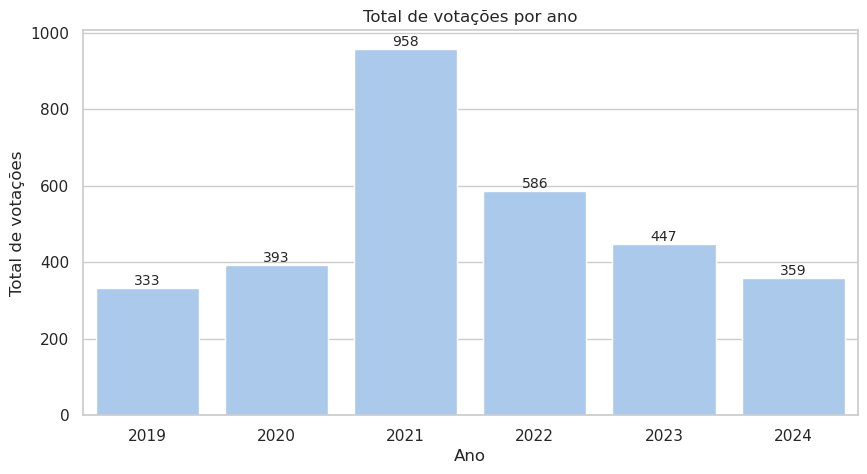

In [9]:
fig = plt.figure(figsize=(10, 5))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

ax = sns.barplot(x=list(range(ANO_INICIO, ANO_FIM + 1)), y=get_total_votacoes(), color="b")

for bar in ax.containers[0]:
    altura = bar.get_height()
    if altura > 0:  
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            altura,  
            f'{int(altura)}',  
            ha='center', va='bottom', fontsize=10  
        )

plt.title('Total de votações por ano')
plt.ylabel('Total de votações')
plt.xlabel('Ano')
plt.show()


Com um Total de 3076 votações coletadas entre 2019 e 2024 vemos que o ano de 2021 tem muito mais votações que os demais anos. Isso pode se dar ao período de maior gravidade da pandêmia e o surgimento de diversas medididas, escandalos e investigações sendo feitas. Uma análise com recorte temporal maior pode comprovar melhor a hipótese.

## Contextualização da posição do governo no período

![linha do tempo](./imagens/linha_do_tempo.png)

O período de 2019 a 2024 consistem em um período marcado por dois governos, um de direita(Bolsonaro) e um de Esquerda(PT). Até metade do governo Bolsonaro a Direita se mantém na Presidência da Câmara, a partir desse momento a Centro Direita assume essa posição.
O periodo contém dois períodos de posse e um ano eleitoral, que influenciam a organização e parcerias partidárias. Além disso foi um período marcado pela Pandêmia de COVID-19 que chacoalhou o cenário político brasieliro. 

## Análises Anuais

In [10]:
def get_networks() -> dict[int, DeputiesNetwork]:
    return {
        2019: DeputiesNetwork(get_file_name(2019), initDistances= True),
        2020: DeputiesNetwork(get_file_name(2020), initDistances= True),
        2021: DeputiesNetwork(get_file_name(2021), initDistances= True),
        2022: DeputiesNetwork(get_file_name(2022), initDistances= True),
        2023: DeputiesNetwork(get_file_name(2023), initDistances= True),
        2024: DeputiesNetwork(get_file_name(2024), initDistances= True)
    }

In [11]:
networks = get_networks()

### 2019

In [12]:
year = 2019

#### Análise Qualitativa

![Partidos 2019](./imagens/2019_p.jpg)|

Olhando os partidos se ve claramente uma distribuição entre partidos do bloco Governista e partidos do Bloco. O Bloco de Oposição aparenta estar mais coêso que o bloco Governista, tendo o PT em seu centro. O Bloco Governista aparenta ter duas regiões mais densas, uma aparentemente formada pelo PSL e NOVO e a outra formada por demais partidos de Direita e Centro.

![Comunidades 2019](./imagens/2019_c.jpg)

Olhando a rede pela comunidades claramente ve-se a organização dita ateriormente, com duas comunidades no Bloco Governista e uma comunidade no Bloco de Oposição. Também podemos ver um possível artefato.

#### Análise Qualitativa

##### Métricas

In [13]:
networks[year].avarege_distance

1.2717181094322314

In [14]:
dep_por_partido = pd.Series({party: len(networks[year].parties[party]) for party in networks[year].parties})

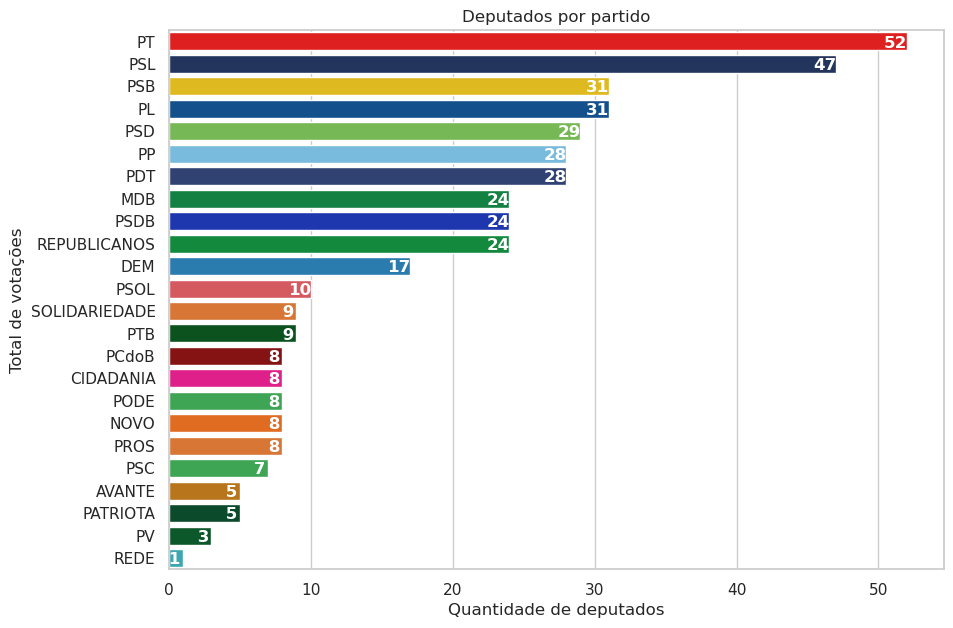

In [15]:
fig = plt.figure(figsize=(10, 7))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = dep_por_partido.sort_values(ascending=False)

ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,)


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - .015 * max(data),  
            s = f'{altura:>2}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
        )


plt.title('Deputados por partido')
plt.ylabel('Total de votações')
plt.xlabel('Quantidade de deputados')
plt.show()

In [16]:
sum(dep_por_partido)

424

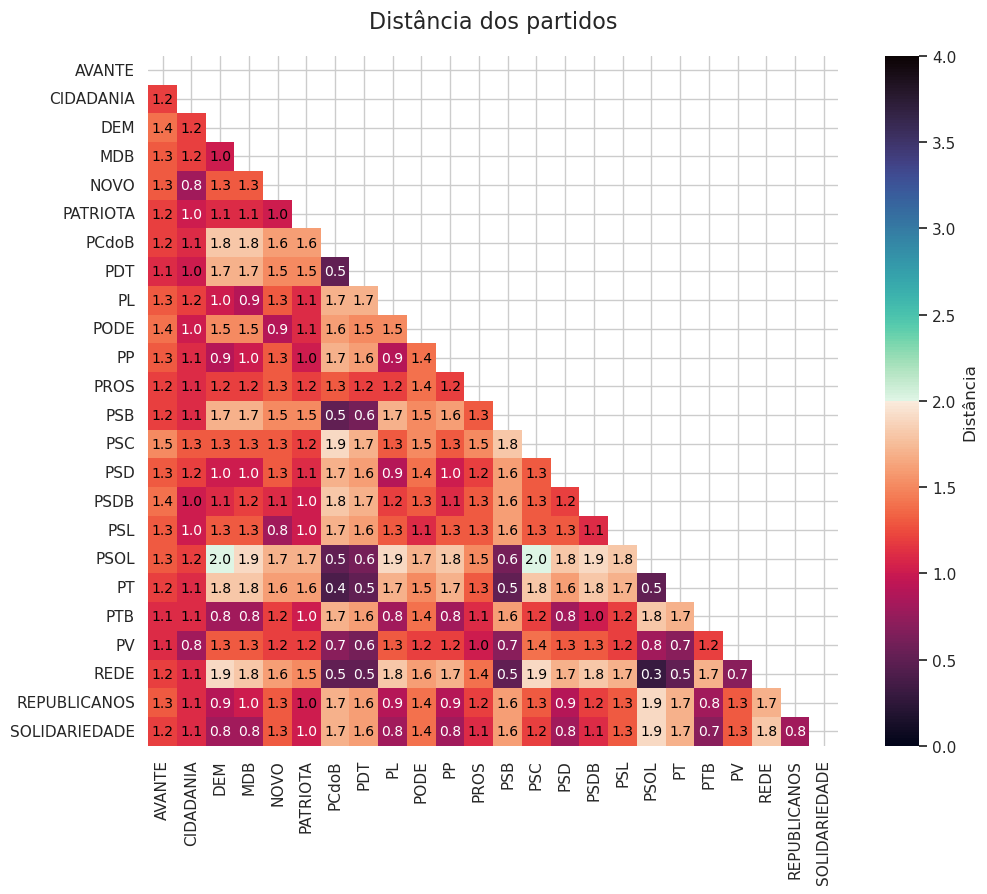

In [17]:
values = pd.DataFrame(networks[year].getPartiesDistances()).sort_index(axis=0).sort_index(axis=1)
mask = np.triu(np.ones_like(values, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    round(values, 1),
    mask=mask,
    vmax=4, 
    vmin=0,
    center=2,  
    annot=False,
    square=True,
    cbar_kws={"shrink": 1, "label": "Distância"},
    cmap= contrast_cmap
    )

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        if not mask[i, j]:  # Ignora as células mascaradas
            value = values.iloc[i, j]
            text_color = "white" if value < 1 else "black"
            ax.text(j + 0.5, i + 0.5, f"{value:.1f}", 
                    ha="center", va="center", color=text_color, fontsize=10)

ax.set_title("Distância dos partidos", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [18]:
lower_triangle_no_diag = np.tril(values.values, k=-1)

std = np.std(lower_triangle_no_diag[lower_triangle_no_diag != 0], ddof=0)

std

0.3573832332510701

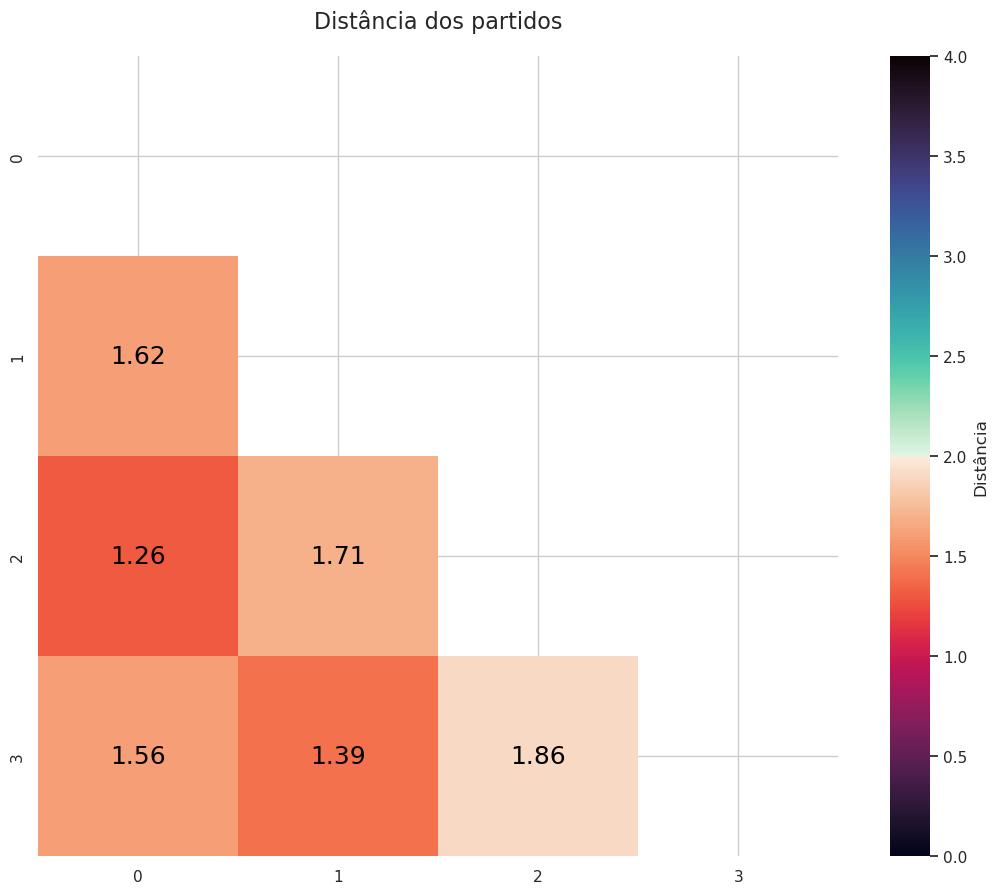

In [19]:
values = pd.DataFrame(networks[year].getCommunitiesDistances()).sort_index(axis=0).sort_index(axis=1)
mask = np.triu(np.ones_like(values, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    round(values, 1),
    mask=mask,
    vmax=4, 
    vmin=0,
    center=2,  
    annot=False,
    square=True,
    cbar_kws={"shrink": 1, "label": "Distância"},
    cmap= contrast_cmap
    )

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        if not mask[i, j]:  # Ignora as células mascaradas
            value = values.iloc[i, j]
            text_color = "white" if value < 1 else "black"
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                    ha="center", va="center", color=text_color, fontsize=18)

ax.set_title("Distância dos partidos", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

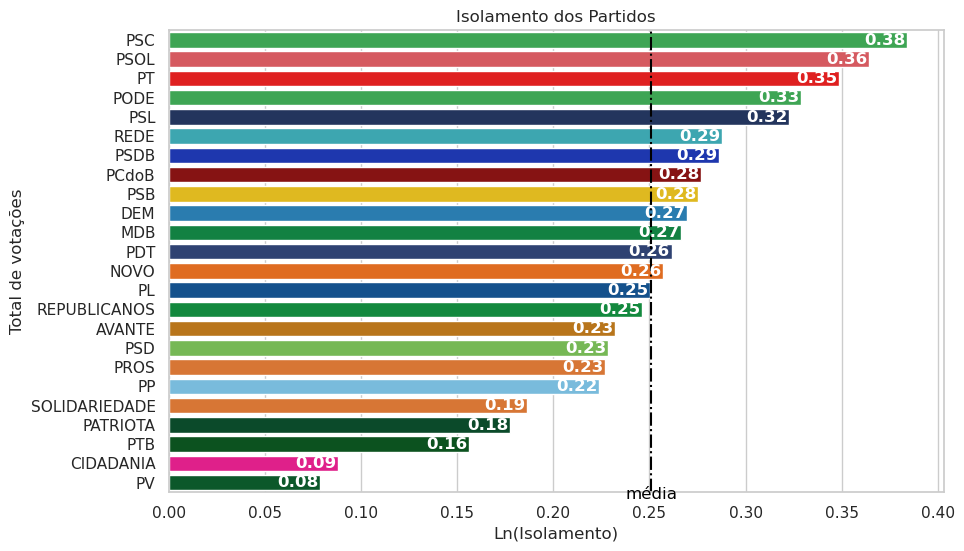

In [20]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getPartiesIsolation()).sort_values(ascending= False).apply(np.log)


ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,
                 )


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - 0.03 * max(data),  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axvline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    x = data.mean(),
    y = len(data.index),
    s = 'média',
    ha='center', va='bottom', fontsize=12, color='black',
)


plt.title('Isolamento dos Partidos')
plt.ylabel('Total de votações')
plt.xlabel('Ln(Isolamento)')
plt.show()

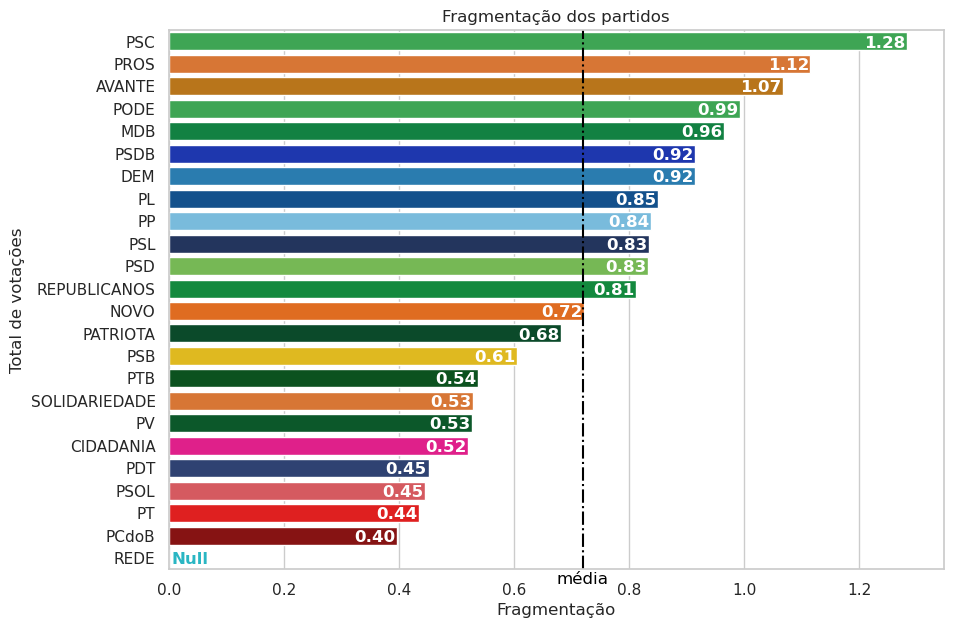

In [21]:
fig = plt.figure(figsize=(10, 7))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getPartiesFragmentation()).sort_values(ascending= False)

ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,)

ax.text(
    x = 0.005,
    y = list(data.index).index('REDE') + .05,
    s = 'Null',
    ha='left', va='center', fontsize=12, color=CORES_PARTIDOS['REDE'], weight='bold',
)


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - 0.03 * max(data),  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
        )


plt.axvline(data.mean(), color='#000', linestyle='dashdot', linewidth=1.5)
ax.text(
    x = 0 + data.mean(),
    y = len(data.index) + 0.3,
    s = 'média',
    ha='center', va='bottom', fontsize=12, color='black',
)


plt.title('Fragmentação dos partidos')
plt.ylabel('Total de votações')
plt.xlabel('Fragmentação')
plt.show()

/tmp/ipykernel_3326/2590619172.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(x= data.index,


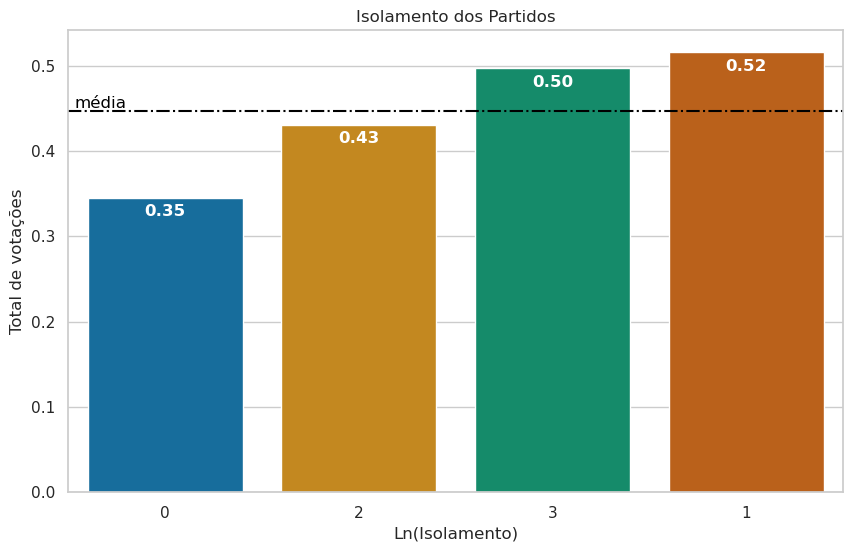

In [22]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getCommunitiesIsolation()).sort_values(ascending= True).apply(np.log)
data.index = data.index.to_series().astype(str)

ax = sns.barplot(x= data.index, 
                 y= data.values, 
                 hue= data.index,
                 palette= sns.color_palette('colorblind'))


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            x = bar.get_x() + bar.get_width()/2,  
            y = altura - 0.025,  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axhline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    y = data.mean(),
    x = - 0.2,
    s = 'média',
    ha='right', va='bottom', fontsize=12, color='black',
)


plt.title('Isolamento dos Partidos')
plt.ylabel('Total de votações')
plt.xlabel('Ln(Isolamento)')
plt.show()

/tmp/ipykernel_3326/1222309535.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(x= data.index,


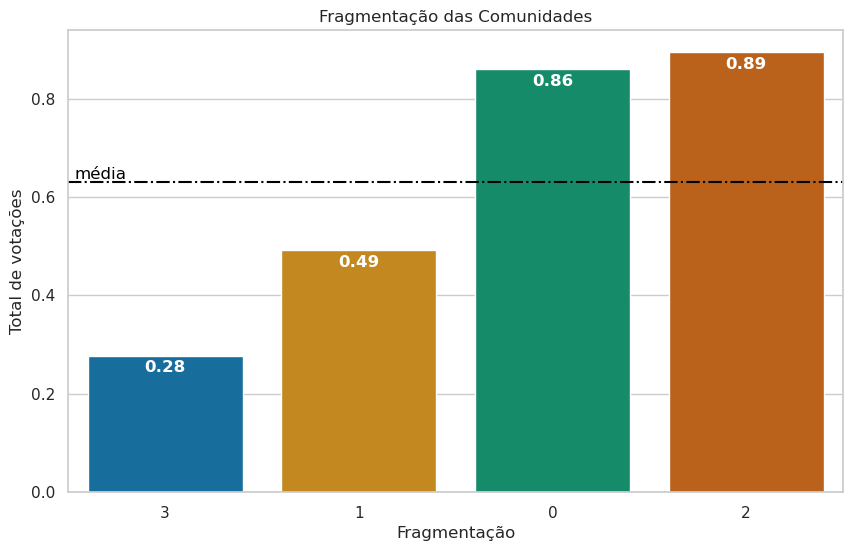

In [23]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getCommunitiesFragmentation()).sort_values(ascending= True)
data.index = data.index.to_series().astype(str)

ax = sns.barplot(x= data.index, 
                 y= data.values, 
                 hue= data.index,
                 palette= sns.color_palette('colorblind'))


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            x = bar.get_x() + bar.get_width()/2,  
            y = altura - 0.04,  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axhline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    y = data.mean(),
    x = - 0.2,
    s = 'média',
    ha='right', va='bottom', fontsize=12, color='black',
)


plt.title('Fragmentação das Comunidades')
plt.ylabel('Total de votações')
plt.xlabel('Fragmentação')
plt.show()

In [24]:
communities = {}

for community_key in networks[year].getCommunities().keys():
    community = pd.Series(networks[year].getPartiesInCommunity(community_key)).apply(len)
    
    communities[community_key] = pd.DataFrame({
        'Deputados por partido': community,
        '% Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),
        'Isolamento': networks[year].getPartiesInCommunitiesIsolation()[community_key]
    })

In [25]:
communities[1].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PT,52,100.00,0.482591
PSB,29,93.55,0.517204
PDT,28,100.00,0.504974
PSOL,10,100.00,0.526885
PCdoB,8,100.00,0.467428
AVANTE,2,40.00,0.400704
PODE,2,25.00,0.768352
PROS,2,25.00,0.398281
PV,2,66.67,0.449946
PSD,2,6.90,0.628417


In [26]:
communities[1]["Deputados por partido"].sum()

139

In [27]:
communities[2].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PL,29,93.55,0.872572
PSD,27,93.10,0.884445
PP,26,92.86,0.897268
MDB,23,95.83,0.946131
REPUBLICANOS,23,95.83,0.876738
PSDB,18,75.00,1.067623
DEM,16,94.12,0.889179
PTB,9,100.00,0.788300
SOLIDARIEDADE,9,100.00,0.799830
PSC,4,57.14,1.168749


In [28]:
communities[2]["Deputados por partido"].sum()

194

In [29]:
communities[0].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PSL,44,93.62,0.878875
NOVO,8,100.00,0.789180
CIDADANIA,7,87.50,0.973206
PODE,6,75.00,0.953142
PSDB,6,25.00,0.994049
PATRIOTA,3,60.00,0.878608
PL,2,6.45,1.043456
PSC,2,28.57,0.820571
PROS,2,25.00,0.924157
AVANTE,2,40.00,1.112159


In [30]:
communities[0]["Deputados por partido"].sum()

88

In [31]:
communities[3].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PSL,3,6.38,0


##### Analise

Os números ajudam a ver com mais detalhes as comunidades. A comunidade 3 aparenta ainda mais ser um artefato, já que ela possui apenas 3 deputados (0.7%).

Dito isso, uma das comunidades(1) representa todo o bloco de oposição já que o executivo se posicionava a direita([aqui](analise.ipynb#contextualização-da-posição-do-governo-no-período)). Essa comunidade tem 139(32,8%) deputados, formada principalmente pelo PT, PSB, PDT, PSOL e PCdoB, ela tem uma fragmentação de 0.49, a mais baixa se desconsiderar-se o artefato. O que mostra que a comunidade é mais coesa que as outras. A comunidade tem 0.52 de isolamento, o mais alto das 4 o que é de se esperar por representar toda a oposição.

Além dessa, existem outras duas comunidades uma de 192 deputados e uma de 88. A primeira(2) é a maior comunidade, ela é composta principalmente pelo PL, PSD, PP MDB, Republicanos, PSDB, DEM, PTB e Soliedaridade, partidos de direita e centro, o que mostra que essa comunidade compõe o bloco governista. Sua fragmentação é de 0.89, a maior fragmentação, o que é compreensivel já que é a maior comunidade da rede e possui muitos partidos que a compõem. Já o isolamento é de 0.43, levente abaixo da média.

Já a última comunidade(0), a menor comunidade se desconsiderar a comunidade artefato, é formada principalmente pelo PSL(50% da comunidade), NOVO, CIDADANIA, PODE e alguns membros do PSDB. Sua fragmentação é de 0.86, muito próxima da comunidade 2. Isso se deve porque a comunidade têm varias deputados dos principais partidos da comunidade 2, um pouco mais de 10%. Já seu isolamento é de 0.35, o menor de todos e bem abaixo da média. Isso mostra um comportamento mais conciliador da comunidade, umas vez que o principal partido da comunidade é o partido do atual executivo, tentando contruir essa boa relação com demais deputasdos, contudo, isso acontece mais com partidos de direita, já que a distância entre a comunidade 0 e 2 é a menor de todas com 1.26. Isso demonstra como ambas as comunidades compõem o bloco Governista. A dúvida é o que tanto se difere do comportamento desses deputados para que o blocxo governista se dividisse em duas comunidas?

#### Analise Textual

Indo para a analise dos discursos conseguimos as resposta para o questionamento e mais detalhes que comprovam as hipóteses. A comunidade 2 defendeu a PEC 98/2019, reforma da previdência, e a PEC 187/2019, que tinha carater de austeridade fiscal nos discursos de seus deputados. Defendeu a exploração dos recursos na Amazônia e o porte de armas de agricultores para a resolução de problemas no campo. Além disso, demonstrou desconfiança com a esqurda, repudiou o PL 2269/2015 que defendia a reformulação da definição de família, e criticou a atuação do executivo, o que pode ser uma explicação para o distanciamento com a comunidade 0. 
  
Já a comunidade 0, manteve seu discurso no entorno da austeridade fiscal e tributário, além da defesa da liberdade de expressão, o que mostra um leve distanciamento das pautas da comunidade 2, além disso defendeu em seus discursos o apio ao governo para melhor governabilidade, o que explica a comunidade 0 ter o menor isolamento, tentanto uma postura um pouco mais conciliadora.

Quando chega-se na comunidade 3, que aparentava ser um artefato, percebe-se que o discurso fica em torno de pautas critãs e conservadoras em relação a família, além da liberdade de expressão. Como a comunidade têm apenas 3 deputados os resumos podem não ser tão representativos em relação aos votos dos candidatos, mas já da pistas de que a comunidade realmente não seja um artefato, validando mais ainda a escolha do algoritmo de detecção de comunidades.

Porfim, a comunidade 1 defende a proteção do meio ambiente e biodiversidade e o combate a queimada e o desmatamento. Defendeu a proteção dos povos indígenas e demarcação de terras, Além da c'ritica a Reforma Tributária. Pautas bem opostas as demais comunidades, explicando o isolamento da comunidade ser o mais alto da rede.

Vale ressaltar que existem alguns pontos em comum entre as comunidades.

### 2020

In [32]:
year = 2020

#### Análise Qualitativa

![Partidos 2020](./imagens/2020_p.jpg)|

Novamente se ve os partidos organizados entre o bloco Governista e o bloco da Oposição. O bloco da oposição desta vez se mostra desoeso entre si mas coeso em seus sub grupos, formando duas regiões uma com o PT e o PSOL e uma com PSB, PCdoB e PDT. Quando se olha o bloco Governista els se organizam em uma grande região pouco coesa, com excessão do NOVO que se encontra bem coeso dentro da regiã. Além disso é possivel ver uma concentração do PSDB numa região mais ao centro do espetro. 

![Comunidades 2020](./imagens/2020_c.jpg)

Quando se olha as comunidades os palpites se comprovam: o bloco governista em uma unica comunidade, enquanto o bloco da oposição se encontra em três comunidades, uma mais o centro, e uma mais a esquerda do espectro Além disso pode-se ver mais dois possiveis artefatos, uma no centro e uma isolada na região governista.

#### Análise Qualitativa

##### Métricas

In [33]:
networks[year].avarege_distance

1.7370744811227954

In [34]:
dep_por_partido = pd.Series({party: len(networks[year].parties[party]) for party in networks[year].parties})

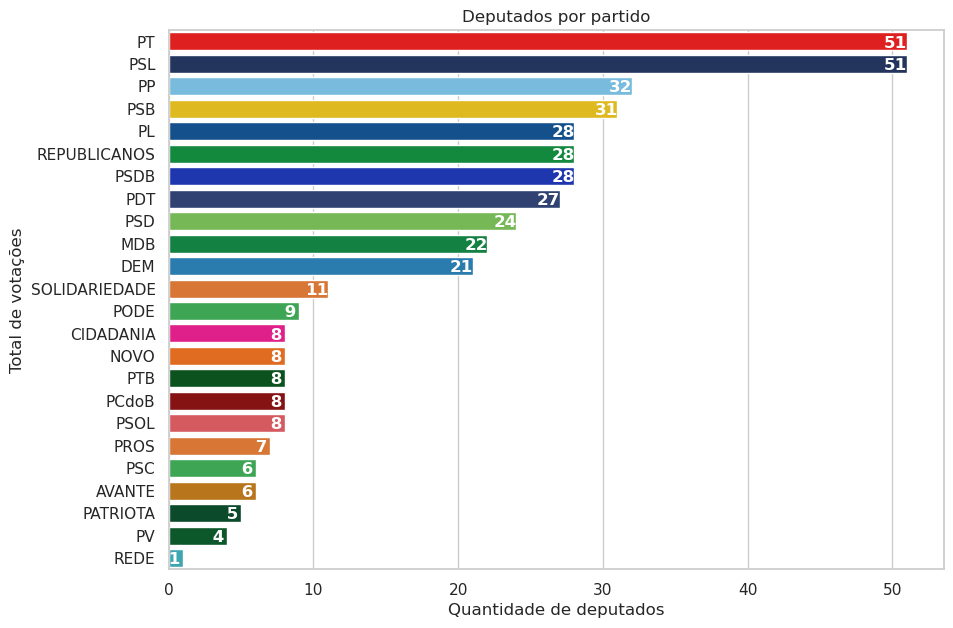

In [35]:
fig = plt.figure(figsize=(10, 7))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = dep_por_partido.sort_values(ascending=False)

ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,)


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - .015 * max(data),  
            s = f'{altura:>2}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
        )


plt.title('Deputados por partido')
plt.ylabel('Total de votações')
plt.xlabel('Quantidade de deputados')
plt.show()

In [36]:
sum(dep_por_partido)

432

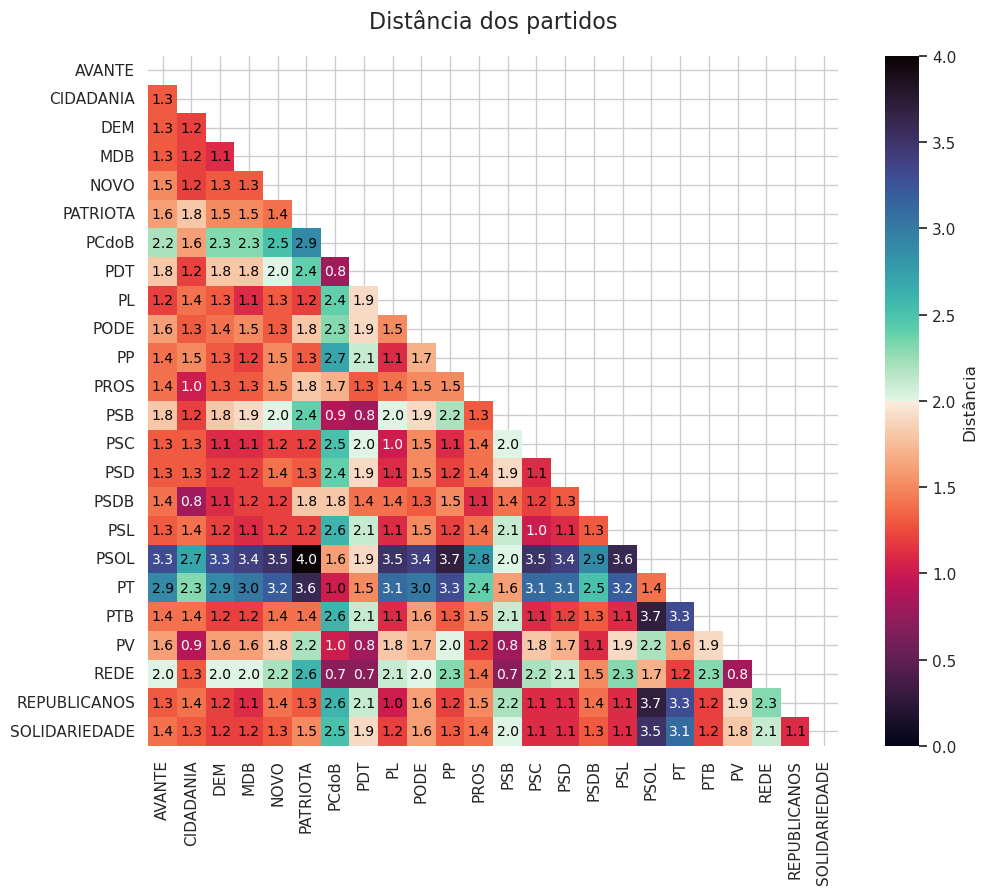

In [37]:
values = pd.DataFrame(networks[year].getPartiesDistances()).sort_index(axis=0).sort_index(axis=1)
mask = np.triu(np.ones_like(values, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    round(values, 1),
    mask=mask,
    vmax=4, 
    vmin=0,
    center=2,  
    annot=False,
    square=True,
    cbar_kws={"shrink": 1, "label": "Distância"},
    cmap= contrast_cmap
    )


for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        if not mask[i, j]:  # Ignora as células mascaradas
            value = values.iloc[i, j]
            text_color = "white" if value < 1 or value > 3 else "black"
            ax.text(j + 0.5, i + 0.5, f"{value:.1f}", 
                    ha="center", va="center", color=text_color, fontsize=10)

ax.set_title("Distância dos partidos", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [38]:
lower_triangle_no_diag = np.tril(values.values, k=-1)

std = np.std(lower_triangle_no_diag[lower_triangle_no_diag != 0], ddof=0)

std

0.7048883398251287

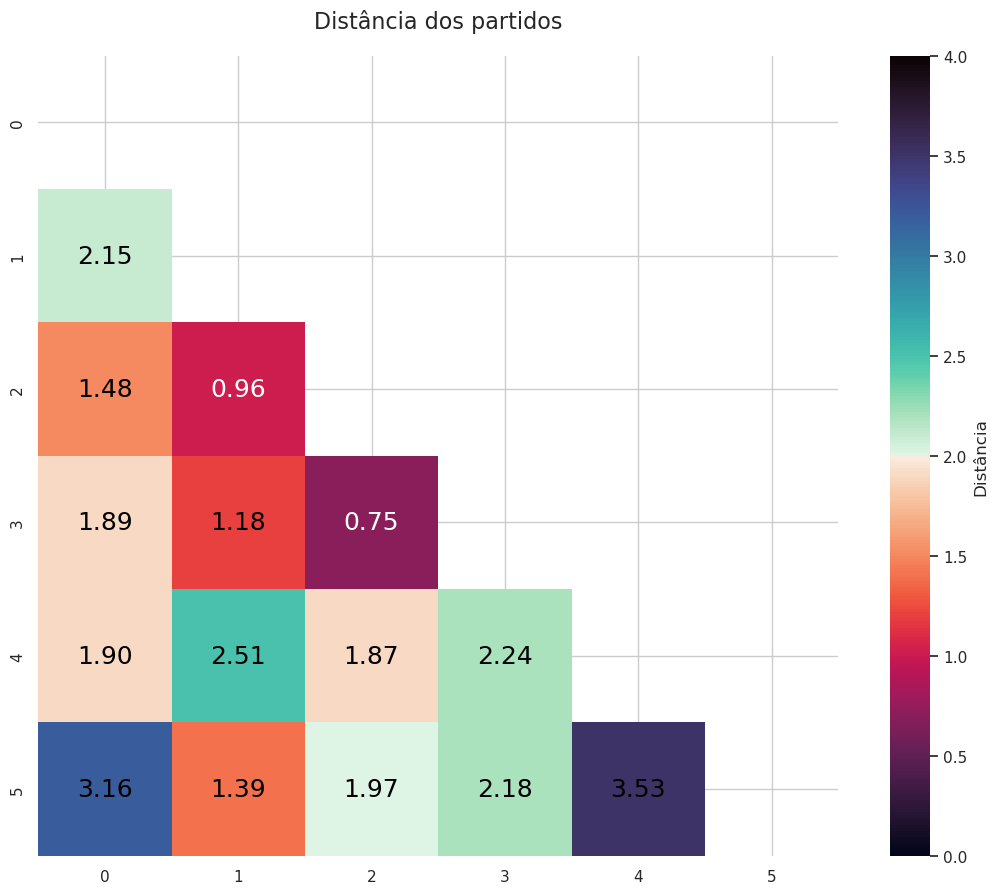

In [39]:
values = pd.DataFrame(networks[year].getCommunitiesDistances()).sort_index(axis=0).sort_index(axis=1)
mask = np.triu(np.ones_like(values, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    round(values, 1),
    mask=mask,
    vmax=4, 
    vmin=0,
    center=2,  
    annot=False,
    square=True,
    cbar_kws={"shrink": 1, "label": "Distância"},
    cmap= contrast_cmap  
    )

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        if not mask[i, j]:  # Ignora as células mascaradas
            value = values.iloc[i, j]
            text_color = "white" if value < 1 else "black"
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                    ha="center", va="center", color=text_color, fontsize=18)

ax.set_title("Distância dos partidos", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

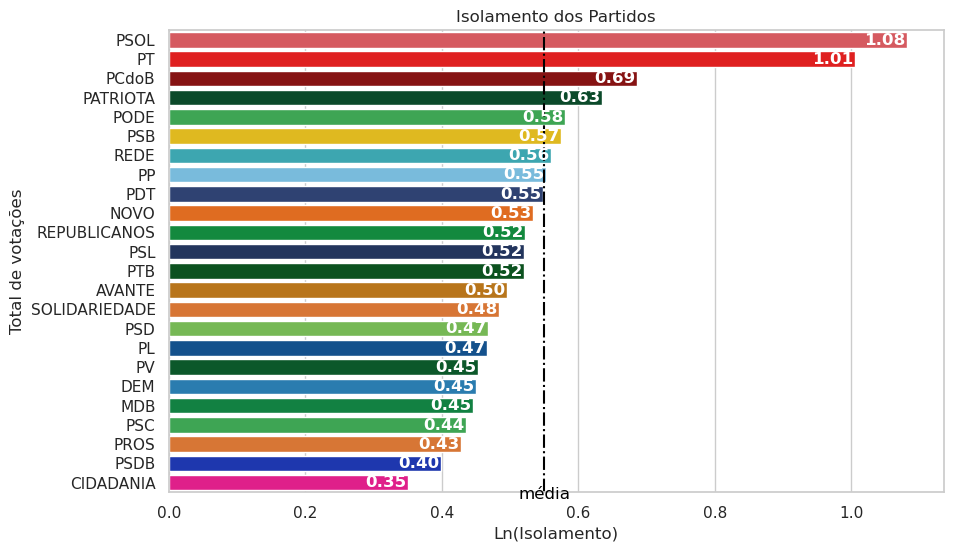

In [40]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getPartiesIsolation()).sort_values(ascending= False).apply(np.log)


ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,
                 )


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - 0.03 * max(data),  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axvline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    x = data.mean(),
    y = len(data.index),
    s = 'média',
    ha='center', va='bottom', fontsize=12, color='black',
)


plt.title('Isolamento dos Partidos')
plt.ylabel('Total de votações')
plt.xlabel('Ln(Isolamento)')
plt.show()

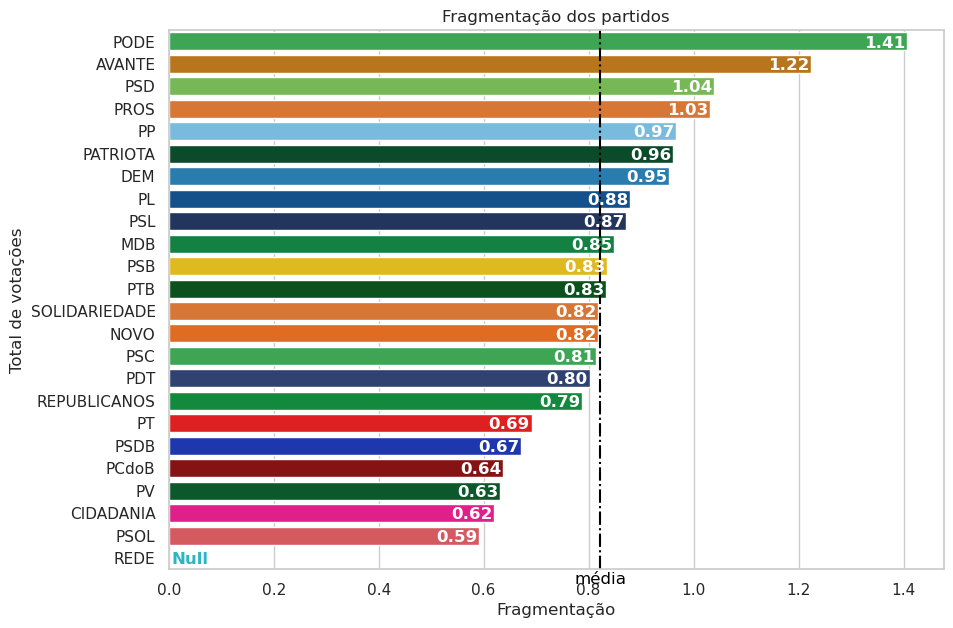

In [41]:
fig = plt.figure(figsize=(10, 7))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getPartiesFragmentation()).sort_values(ascending= False)

ax = sns.barplot(y= data.index, 
                 x= data.values, 
                 hue= data.index, 
                 palette=CORES_PARTIDOS,)

ax.text(
    x = 0.005,
    y = list(data.index).index('REDE') + .05,
    s = 'Null',
    ha='left', va='center', fontsize=12, color=CORES_PARTIDOS['REDE'], weight='bold',
)


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            y = bar.get_y() + bar.get_height(),  
            x = altura - 0.03 * max(data),  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
        )


plt.axvline(data.mean(), color='#000', linestyle='dashdot', linewidth=1.5)
ax.text(
    x = 0 + data.mean(),
    y = len(data.index) + 0.3,
    s = 'média',
    ha='center', va='bottom', fontsize=12, color='black',
)


plt.title('Fragmentação dos partidos')
plt.ylabel('Total de votações')
plt.xlabel('Fragmentação')
plt.show()

/tmp/ipykernel_3326/2533984207.py:9: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(x= data.index,


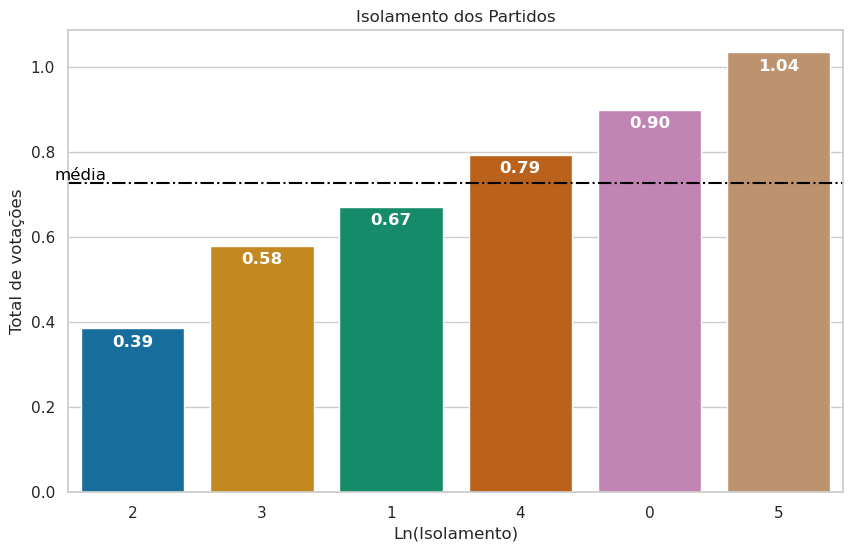

In [42]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getCommunitiesIsolation()).sort_values(ascending= True).apply(np.log)
data.index = data.index.to_series().astype(str)

ax = sns.barplot(x= data.index, 
                 y= data.values, 
                 hue= data.index,
                 palette= sns.color_palette('colorblind'))


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            x = bar.get_x() + bar.get_width()/2,  
            y = altura - 0.05,  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axhline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    y = data.mean(),
    x = - 0.2,
    s = 'média',
    ha='right', va='bottom', fontsize=12, color='black',
)


plt.title('Isolamento dos Partidos')
plt.ylabel('Total de votações')
plt.xlabel('Ln(Isolamento)')
plt.show()

/tmp/ipykernel_3326/2637102439.py:9: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.barplot(x= data.index,


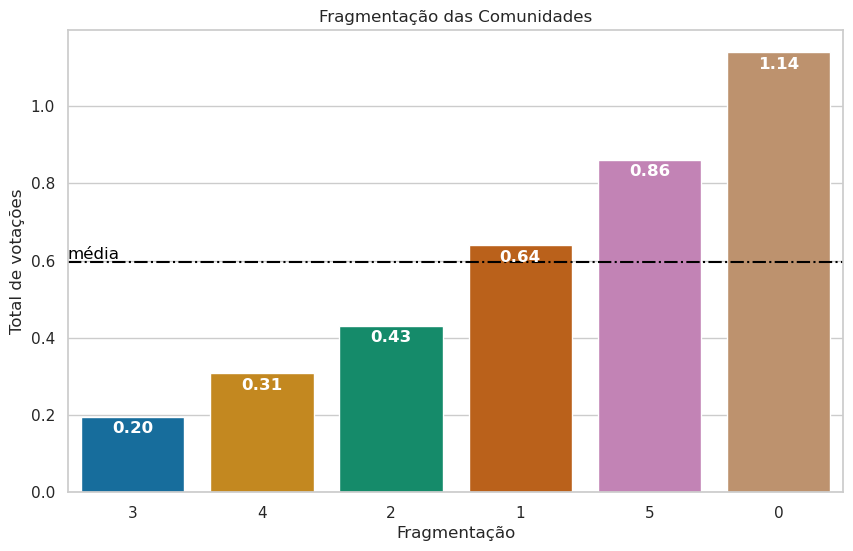

In [43]:
fig = plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

data = pd.Series(networks[year].getCommunitiesFragmentation()).sort_values(ascending= True)
data.index = data.index.to_series().astype(str)

ax = sns.barplot(x= data.index, 
                 y= data.values, 
                 hue= data.index,
                 palette= sns.color_palette('colorblind'))


for bar, altura in zip(ax.patches, data.values):
    if altura > 0:
        ax.text(
            x = bar.get_x() + bar.get_width()/2,  
            y = altura - 0.05,  
            s = f'{altura:>2.2f}',  
            ha='center', va='bottom', fontsize=12, color='white', weight= 'bold',
            
        )

plt.axhline(data.mean(), color='black', linestyle='dashdot', linewidth=1.5)
ax.text(
    y = data.mean(),
    x = - 0.1,
    s = 'média',
    ha='right', va='bottom', fontsize=12, color='black',
)


plt.title('Fragmentação das Comunidades')
plt.ylabel('Total de votações')
plt.xlabel('Fragmentação')
plt.show()

In [44]:
communities = {}

for community_key in networks[year].getCommunities().keys():
    community = pd.Series(networks[year].getPartiesInCommunity(community_key)).apply(len)
    
    communities[community_key] = pd.DataFrame({
        'Deputados por partido': community,
        '% Partido na Comunidade':(community / dep_por_partido).dropna().mul(100).round(2),
        'Isolamento': networks[year].getPartiesInCommunitiesIsolation()[community_key]
    })

In [45]:
communities[0].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PSL,50,98.04,1.124091
PP,31,96.88,1.194470
REPUBLICANOS,28,100.00,1.155743
PSDB,27,96.43,1.282080
PL,25,89.29,1.065762
PSD,23,95.83,1.142656
DEM,21,100.00,1.177692
MDB,21,95.45,1.116419
SOLIDARIEDADE,11,100.00,1.180824
NOVO,8,100.00,1.296707


In [46]:
communities[0].sort_values('Isolamento', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PSB,3,9.68,1.364261
PATRIOTA,5,100.00,1.358696
CIDADANIA,8,100.00,1.307702
NOVO,8,100.00,1.296707
PSDB,27,96.43,1.282080
AVANTE,4,66.67,1.238915
PTB,8,100.00,1.195214
PP,31,96.88,1.194470
SOLIDARIEDADE,11,100.00,1.180824
DEM,21,100.00,1.177692


In [47]:
communities[0]["Deputados por partido"].sum()

288

In [48]:
communities[4].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PODE,3,33.33,0


In [49]:
communities[2].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PSB,6,19.35,0.425239
PROS,4,57.14,0.495189
PV,2,50.00,0.392140
PDT,2,7.41,0.515409
AVANTE,1,16.67,0.388509
PODE,1,11.11,0.441543
PL,1,3.57,0.544529
PSD,1,4.17,0.385697
PSDB,1,3.57,0.438998
PSL,1,1.96,0.615642


In [50]:
communities[2]["Deputados por partido"].sum()

20

In [51]:
communities[3].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
MDB,1,4.55,0.245971
PL,1,3.57,0.268872
PODE,1,11.11,0.258694
PP,1,3.12,0.268024


In [52]:
communities[1].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PDT,23,85.19,0.640991
PSB,22,70.97,0.657154
PCdoB,8,100.00,0.708454
PV,2,50.00,0.575859
AVANTE,1,16.67,0.737824
PL,1,3.57,0.683898
REDE,1,100.00,0.613276


In [53]:
communities[1]["Deputados por partido"].sum()

58

In [54]:
communities[5].sort_values('Deputados por partido', ascending=False)

,Deputados por partido,% Partido na Comunidade,Isolamento
PT,51,100.0,1.420178
PSOL,8,100.0,1.420178


In [55]:
communities[5]["Deputados por partido"].sum()

59

##### Analise

Quando comparado com o ano de 2019, a rede de 2020 tem uma distância média bem maior, um aumento de 36,6% esse impacto é perceptívelna distancia entre os partidos que teve um desvio padrão duas vezes maior.

Indo para as comunidades, 4 grandes comunidades de 2 possiveis artefatos. Dessas, a comunidade 0 representa o bloco Governista, com 288 deputados, uma comunidade gigantesca com 66.67% dos deputados do ano de 2020. Composta pelo PSL, PP, REPUBLICANOS, PSDB, PL, PSD, DEM, MDB, SOLIEDARIEDADE, NOVO, CIDADANIA, PTB, PSC, PATRIOTA. A comunidade tem um a fragmentação de 1.14, a maior de todas as comunidades, o que é compreensível devido ao seu tamanho. Quando se olha com mais detalhes os partidos dentro da comunidade vê se partidos com isolamento levemente maior( por volta de 1.3), demonstrando que, mesmo dentro de uma mesma comunidade e votando em conjunto, alguns partidos votam levemente diferente em relação aos demais. Quando soma-se isso a uma análise da fragmentação dos partidos que compões esse grupo, alguns desses partidos com isolamento mais alto tem uma fragmentação bem baixa formando "panelinhas" dentro da comunidades. Esse partdidos são o PSDB, NOVO E CIDADANIA. Analisando o Isolamento desses partidos, o PSDB e o CIDADANIA tem as os dois menores isolamentos da rede, mostrando uma posição mais concialiadora em relação a comunidade 0, enquanto o NOVO tem o terceiro maior isolamento dos partidos quer compõem a comunidade 0, mostrando uma posição mais radical em relação a rede. Os resumos podem confirmar isso?

Próximo a 0 existe a comunidade 4 que aparenta ser um artefato, possui apenas 3 deputados do partido PODE, representando 33% da composição do partidos e 0.69% da rede. 

Indo mais ao centro, existe a comunidade 2, uma comunidade pequena, de 20 deputados,4.63%, composta por alguns deputados da esquerda, alguns membros do PSB, PDT e PV, e alguns membros da direita, um membros do AVANTE, PODE, PSD, PSDB, PL e PSL, além disso alguns partidos pequenos tem mais de 50% de seus mebros nessa rede, partidos como PROS e o PV. ë uma rede cm uma fragemntação abaixo da média com 0.43 e seu isolamento é o mais baixo de todos, compreensivel uma vez que é uma comunidade que representa o centro do espectro político.

Levemente ligada a comunidade 2 tem a 3, outra comunidade que aparenta ser um artefato com 4 deputados de partidos diferentes.

Chegando a Esquerda do espectro, existem 2 comunidades, a comunidade 1, mais ao cento e a 5 mais a esquerda. A comunidade 1 é média com 58 deputados, 13.42% da comunidade. A comunidade é formada pelo PDT, boa parte do PSB e todo o PCdoB. ë uma comunidade com isolamento de 0.67 e, abaixo da média, o que é compreensível devido a posição mais ao centro, mesmo que a esquerda. Já sua fragmentação é de 0.64, bem próximo da média. Por fim a comunidade 5 é uma comunidade 5 também é média, com 59% dos deputados da rede, 13.66% formada por 100% do PT e do PSOL. A comunidade tem um isolamento 1.04, o maior dentro as demais, o que mostra uma posição mais extrema. Já sua fragmentação é de 0.86, bem acima da média e a segunda maior. Quando se olha pro isolamento interno, isso se torna compreensível uma vez que os partdios tem 1.42 de isolamento entre si. Isso é espresso na distancia dos partidos. O PT etsa mais próximo do PCdoB, que está na comuniddade 1, do que o PSOL,  que esta na própria comunidade. E quando se olha para a fragmentação desses partidos, o PSOL tema a mais baixa da rede, 0.59, e o PT uma das mais baixas, 0.69, mostrando que os partidos são coesos, mas se distanciam, podendo até dizer que eles poderiam ser de outra comunidade. levando isso em conta, o que descoesinou tanto o campo da oposição para formar duas comunidades, e o que diferencia tanto o PSOl do PT?



#### Analise Textual

A comunidaade 0 Defende a cooperação pupblico privada, segurança financeirar controle da dívida, liberdade de expressão , diminuição da cicotomia entre servidores públicos e a socviedade, garantirm a liberdade e responsabilidade dos gestores locais(prefeitos e governadores). Quando olhamos pros partidos destacados anteriormente. O PSDB e o CIDADANIA defendem uma intervenção para conter a pandemia, o que entre em contraste com a defesa da liberdade e resposabilidade de gestores do locais do resto da comunidade. Já o partido NOVO uma menor intervenção do Estado na econômia, o que difere a comunidade conter os gastos e a divida pública. Comprovando as hipóteses apresentadas anteriormente.

A comunidade 4 Apoia o FUNDEB. Mas pouco conclusiva para dizer que náo é um artefato, já que muito do quer foi resumido não se refere a situação nacional. Analise conclusiva apenas analisando a proposições votadas.

Comunidade 2 foca em defender os idosos e população vulneravel durante a pandemia, além de defenderem a reforma da previdência.

Comunidade 3 não têm nada conclusivo, defendem um projeto especifico de escopo local.

Comunidade 1 Defende a Reforma do FUNDEB, proteção da vida da população. Defesa dos servidores públicos. Proteção da economia e gerar empregos. Além disse diversas críticas ao Governo Bolsonaro e sua gestão da pandemia e por ir contra a orientações da OMS, além decríticas relacionadas a valorização da ditadura millitar. 

Comunidade 5 - LLama Bugou, vou regerar.